In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import xgboost as xgb
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
#!python -m wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

In [3]:
df = pd.read_csv("housing.csv")

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Data Preparation

In [5]:
df.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
df.ocean_proximity.replace("<1H OCEAN", "1H OCEAN", inplace = True)

In [7]:
df.ocean_proximity.value_counts()

1H OCEAN      9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.shape

(20640, 10)

In [9]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [10]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [11]:
df['median_house_value']=np.log1p(df['median_house_value'])

### SPLITTING THE DATASET FOR TRAINING AND TEST:

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [13]:
train_dict = df_train.to_dict(orient='records')

In [14]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

### DecisionTree

In [15]:
model_dt = DecisionTreeRegressor(max_depth=1)
model_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [16]:
print(export_text(model_dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



C:\Users\midej\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### RandomForest

In [17]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [18]:
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.2457383433183843

#### Tuning

In [19]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

In [20]:
df_scores

,n_estimators,rmse
0,10,0.245738
1,20,0.239262
2,30,0.235717
3,40,0.234583
4,50,0.233104
5,60,0.232843
6,70,0.232384
7,80,0.232527
8,90,0.232215
9,100,0.231968


#### max_depth

In [21]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [22]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.255042
1,10,20,0.252784
2,10,30,0.251647
3,10,40,0.251062
4,10,50,0.250192
...,...,...,...
75,25,160,0.231484
76,25,170,0.231440
77,25,180,0.231598
78,25,190,0.231603


#### Feature Importance

In [23]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, 
                           random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [24]:
rf.feature_importances_

array([1.69573183e-02, 3.30938997e-02, 1.01333971e-01, 9.62649876e-02,
       3.62912907e-01, 3.00723750e-03, 3.10900842e-01, 3.56806263e-04,
       4.48661972e-04, 4.22762446e-03, 3.09180197e-02, 1.90412562e-02,
       2.05364687e-02])

In [25]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names()
df_importances['importance'] = rf.feature_importances_
df_importances

C:\Users\midej\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,feature,importance
0,households,0.016957
1,housing_median_age,0.033094
2,latitude,0.101334
3,longitude,0.096265
4,median_income,0.362913
5,ocean_proximity=1H OCEAN,0.003007
6,ocean_proximity=INLAND,0.310901
7,ocean_proximity=ISLAND,0.000357
8,ocean_proximity=NEAR BAY,0.000449
9,ocean_proximity=NEAR OCEAN,0.004228


In [26]:
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.362913
6,ocean_proximity=INLAND,0.310901
2,latitude,0.101334
3,longitude,0.096265
1,housing_median_age,0.033094


### XGBoost

In [27]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [28]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [29]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

#### eta=0.3

In [30]:
scores = {}

In [31]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [32]:
scores['eta=0.3'] = parse_xgb_output(output)

In [33]:
scores['eta=0.3']

,num_iter,train_auc,val_auc
0,0,8.12733,8.13245
1,5,1.40218,1.40741
2,10,0.34481,0.35782
3,15,0.23555,0.26044
4,20,0.21580,0.24624
5,25,0.20395,0.24099
6,30,0.19440,0.23741
7,35,0.18637,0.23562
8,40,0.17983,0.23419
9,45,0.17468,0.23279


#### eta = 0.1

In [34]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [35]:
scores['eta=0.1'] = parse_xgb_output(output)

In [36]:
scores['eta=0.1'] 

,num_iter,train_auc,val_auc
0,0,10.44372,10.44938
1,5,6.17513,6.17987
2,10,3.65741,3.66135
3,15,2.17500,2.17928
4,20,1.30499,1.31054
5,25,0.79933,0.80657
6,30,0.51144,0.52189
7,35,0.35700,0.37264
8,40,0.27984,0.30053
9,45,0.24350,0.26829


(0.0, 10.0)

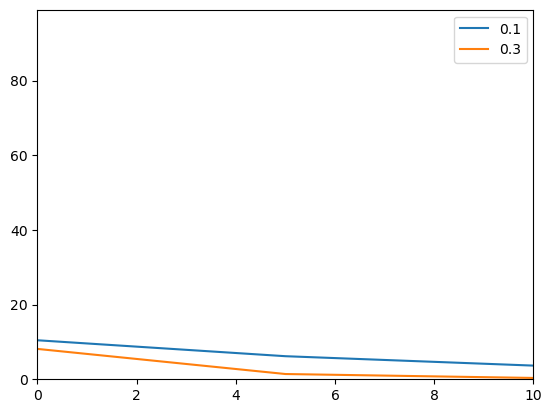

In [37]:
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()

plt.ylim([0, 99])
plt.xlim([0, 10])